In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

In [6]:
data = pd.read_csv('/content/drive/MyDrive/sample.csv', header = 0)

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import lightgbm as lgb
import xgboost as xgb

In [8]:
X = data.iloc[:, 1:]
y = data['TARGET']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify = y, random_state = 2021)

In [10]:
#LightGBM 실습
model = lgb.LGBMClassifier(is_unbalance=True, objective = 'binary', metric= 'cross-entropy')
param_space = {'learning rate': [0.01,0.1,0.25,0.5],
               'max_depth': [5,6,7,10,15],
               'num_levels': [5,7,9,10,15]}
              #'boosting': ['gbdt','rf']}

cv = StratifiedKFold(n_splits =3)
grid_search = GridSearchCV(model, param_grid=param_space, cv=cv, 
                           scoring = ['f1', 'precision', 'recall','accuracy'],refit= 'recall', n_jobs= -1)
grid_search.fit(train_x,train_y)
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_model.pkl')

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


['best_model.pkl']

In [11]:
best_model = joblib.load(f'best_model.pkl')
pred_train_y = best_model.predict(train_x)
pred_test_y = best_model.predict(test_x)

In [12]:
def model_evaluation(true,pred): #이상치를 중심으로 결과를 판단해야 함

  print('Confusion Matrix') #Row = True / Column = pred
  print(confusion_matrix(true, pred, labels=[1,0]))
  print('\n')
  print(f'Accuracy: {accuracy_score(true,pred)}')
  print(f'Recall: {recall_score(true,pred,pos_label=1)}') #pred-이상 (실제로 정상 관측치 중에서 모델이 정상으로 예측한 비율)
  print(f'precision: {precision_score(true,pred,pos_label=1)}') # True-이상 / Pred-Total-이상 (모델이 정상으로 판단한 관측치 중 실제로 정상치였던 비율)
  print(f'F1: {f1_score(true, pred, pos_label=1)}]') #Precision과 Recall의 조화평균

In [13]:
model_evaluation(train_y, pred_train_y)

Confusion Matrix
[[ 449    0]
 [  22 6978]]


Accuracy: 0.997046583434018
Recall: 1.0
precision: 0.9532908704883227
F1: 0.9760869565217392]


In [14]:
model_evaluation(test_y,pred_test_y)

Confusion Matrix
[[  50  143]
 [  85 2915]]


Accuracy: 0.9285937989351707
Recall: 0.25906735751295334
precision: 0.37037037037037035
F1: 0.3048780487804878]


In [15]:
true_y = list(test_y)
pred_y = list(pred_test_y)

new_label = []

for i,(true,pred) in enumerate(zip(true_y,pred_y)):
  if (true ==1) and (pred == 1):
    new_label.append('TP')
  elif (true == 1)and (pred == 0):
    new_label.append('TN')
  elif (true == 0)and (pred == 1): 
    new_label.append('FN')
  elif (true == 0)and (pred == 0): 
    new_label.append('FP')

In [16]:
from collections import Counter
Counter(new_label)

Counter({'FN': 85, 'FP': 2915, 'TN': 143, 'TP': 50})

In [17]:
temp_x = test_x

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
temp_x = pd.DataFrame(scaler.fit_transform(temp_x), columns = temp_x.columns)

In [19]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

In [44]:
def clustering(X, cluster_type):

    n_clusters = [2,3,4,5,6,7,8]
    score_list = []
    for n in n_clusters:

      if cluster_type =='Kmeans':
        cluster = KMeans(n_clusters=n,init='k-means++',random_state=2021)
      elif cluster_type =='Hierarchical':
        cluster = AgglomerativeClustering(n_clusters=n)
      else:
        print('Check Model Type')
        raise NameError

      cluster.fit(X)
      c_label = cluster.labels_
      score = silhouette_score(X, c_label)
      score_list.append(score)

    best_n = n_clusters[np.argmax(score_list)]
    print(f'Optimal number of cluster - {cluster_type}: {best_n}')

    if cluster_type == 'Kmeans' :
      best_cluster = KMeans(n_clusters=4, init='k-means++',random_state=2021)
    else:
      best_cluster = AgglomerativeClustering(n_clusters=4)

    best_cluster.fit(X)

    best_label = best_cluster.labels_

    return best_label, best_n, score_list, n_clusters

In [45]:
k_label,k_best_n,k_score_list,n_clusters =clustering(temp_x, 'Kmeans')
h_label,h_best_n,h_score_list,n_clusters =clustering(temp_x, 'Hierarchical')

Optimal number of cluster - Kmeans: 2
Optimal number of cluster - Hierarchical: 2


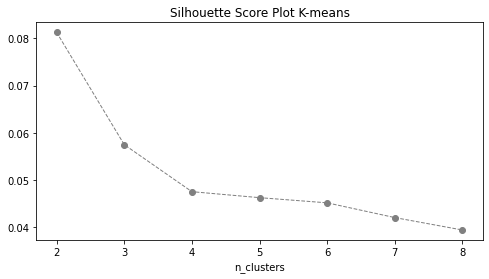

In [46]:
plt.figure(figsize=(8,4))
plt.plot(k_score_list, marker='o',color = 'gray',lw=1, ls='--')
plt.title('Silhouette Score Plot K-means')
plt.xlabel('n_clusters')
plt.xticks(np.arange(len(n_clusters)),n_clusters)
plt.show()

In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

color_list = {'green','red','blue','navy', 'magenta','skyblue','black','purple','lightgreen','steelblue','darkblue','skyblue','gray'}
color_dict = {'TP':'red', 'TN': 'blue', 'FP': 'green','FN':'yellow'}
color_map_k = [color_list[e] for e in k_label]
color_map_h = [color_list[e] for e in h_label]
color_label = [color_dict[label] for label in new_label]

tsne = TSNE(n_components=2)
trans_tsne = tsne.fit_transform(temp_x)
pca = PCA(n_components=2)
trans_pca = pca.fit_transform(temp_x)

TypeError: ignored

In [ ]:
f, ax = plt.subplots(2,3)
f.set_figheiht(12)
f.set_figwidth(15)

ax[0][0].scatter(trans_tsne[:,0],trans_tsne[:,1],s=8,c=color_label)
ax[0][0]